In [3]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

In [6]:
import os
os.chdir('../methods')
import lsci, supr, conf
os.chdir('../examples')

In [2]:
def split_data(data, lag, horizon):
    horizon = horizon-1
    y_t = data[(lag + horizon):][:,None]
    x_t = np.stack([data[(lag-i-1):(-(i+1+horizon))] for i in range(lag)], axis = 1)
    return x_t.copy(), y_t.copy()

In [3]:
class ANO_layer(nnx.Module):
  def __init__(self, width, rngs: nnx.Rngs):
    self.linear = nnx.Linear(width, width, rngs=rngs)
    # self.bn = nnx.BatchNorm(dmid, rngs=rngs)
    # self.dropout = nnx.Dropout(0.2, rngs=rngs)
    self.linear_out = nnx.Linear(width, width, rngs=rngs)

  def __call__(self, x):
    # channel mix
    h = self.linear(x)

    # spatial mix
    g = jnp.mean(x, axis = (1, 2))[:,None,None,:]

    # sum
    x = h + g
    x = nnx.relu(x)

    return self.linear_out(x)

class encode_layer(nnx.Module):
  def __init__(self, in_dim, out_dim, rngs):
    self.linear = nnx.Linear(in_dim, out_dim, rngs=rngs)

  def __call__(self, x):
    return self.linear(x)

class DeepANO(nnx.Module):
  def __init__(self, in_dim, width, out_dim, rngs):
    self.encode_layer = encode_layer(in_dim, width, rngs)
    self.ano1 = ANO_layer(width, rngs)
    self.ano2 = ANO_layer(width, rngs)
    self.ano3 = ANO_layer(width, rngs)
    self.decode_layer = encode_layer(width, out_dim, rngs)

  def __call__(self, x):
    x = self.encode_layer(x)
    x = self.ano1(x)
    x = self.ano2(x)
    x = self.ano3(x)
    x = self.decode_layer(x)
    return x

@nnx.jit  # Automatic state management
def train_step(model, optimizer, x, y):
  def loss_fn(model):
    y_pred = model(x)
    y_diff = jnp.diff(y_pred, axis = 0)
    return jnp.mean((y_pred - y) ** 2) + jnp.mean(y_diff**2)

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # In place updates.

  return loss

@nnx.jit  # Automatic state management
def refine_step(model, optimizer, x, y):
  def loss_fn(model):
    y_pred = model(model(x))
    return jnp.mean((y_pred - y) ** 2)

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # In place updates.

  return loss

In [4]:
key = random.PRNGKey(0)
t = jnp.linspace(0, 1, 100)
f = jnp.sin(2 * math.pi * t)

s = jnp.linspace(-2*math.pi, 2*math.pi, 501)

amp = jnp.sin(s)
sd = jnp.cos(s - 2*math.pi)

x = amp[:,None] * f[None,:]
x = x + 0.25 * (1.15 + sd)[:,None] * random.normal(key, x.shape)

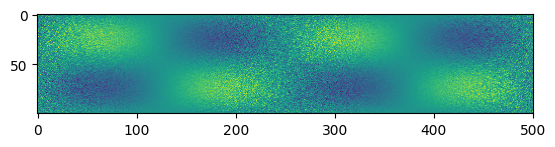

In [5]:
plt.imshow(x.T)

In [6]:
x, y = split_data(x, 1, 1)
x = x[:,:,:,None]
y = y[:,:,:,None]

In [7]:
model = DeepANO(1, 50, 1, nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(1e-3)) 

epochs = 50
nbat = 50
for _ in trange(epochs):
  for i in trange(len(x)//nbat, leave = False):
    xi = x[i*nbat:(i+1)*nbat]
    yi = y[i*nbat:(i+1)*nbat]

    loss = train_step(model, optimizer, xi, yi)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
key = random.PRNGKey(1)
t = jnp.linspace(0, 1, 100)
f = jnp.sin(2 * math.pi * t)

s = jnp.linspace(-2*math.pi, 2*math.pi, 501)

amp = jnp.sin(s)
sd = jnp.cos(s - 2*math.pi)

x = amp[:,None] * f[None,:]
x = x + 0.25 * (1.15 + sd)[:,None] * random.normal(key, x.shape)

x, y = split_data(x, 1, 1)
x = x[:,:,:,None]
y = y[:,:,:,None]

yhat = model(x)

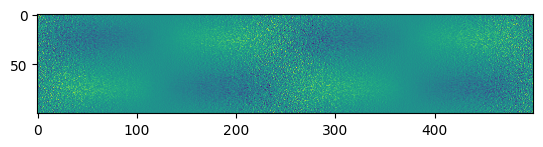

In [11]:
res = (yhat - y).squeeze()
plt.imshow(res.T)
plt.show()

res = jnp.abs(yhat - y).squeeze()
k = jnp.quantile(res, 0.91, axis = 0)

In [13]:
key = random.PRNGKey(2)
t = jnp.linspace(0, 1, 100)
f = jnp.sin(2 * math.pi * t)

s = jnp.linspace(-2*math.pi, 2*math.pi, 501)

amp = jnp.sin(s)
sd = jnp.cos(s - 2*math.pi)

x = amp[:,None] * f[None,:]
x = x + 0.25 * (1.15 + sd)[:,None] * random.normal(key, x.shape)

x, y = split_data(x, 1, 1)
x = x[:,:,:,None]
y = y[:,:,:,None]

yhat = model(x)

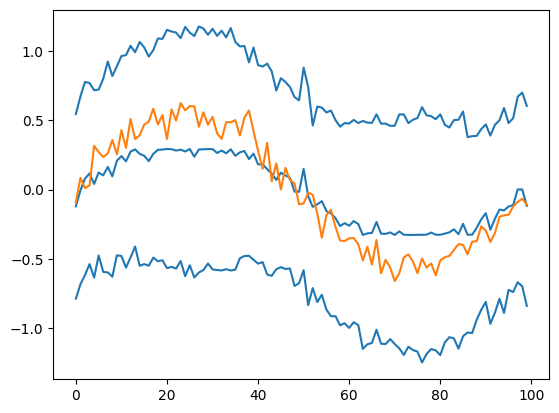

In [22]:
j = 100
yhatj = yhat[j].squeeze()
yj = y[j].squeeze()

plt.plot(yhatj + k, c = 'C0')
plt.plot(yhatj - k, c = 'C0')
plt.plot(yhatj, c = 'C0')
plt.plot(yj.squeeze(), c = 'C1')

In [16]:
risk = jnp.mean(((y.squeeze() < yhat.squeeze() + k)*(y.squeeze() > yhat.squeeze() - k)), axis = 1)

Array(0.90893996, dtype=float32)

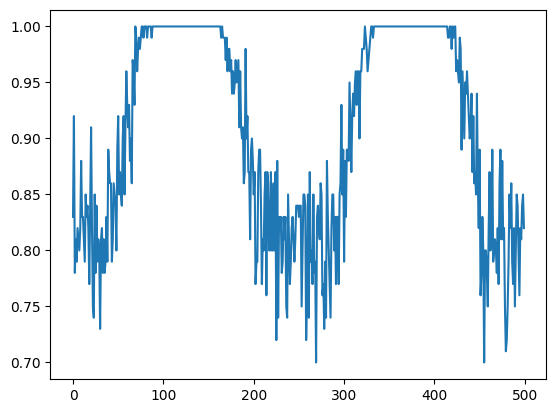

In [17]:
plt.plot(risk)
jnp.mean(risk)